# Linear Models

In [1]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get Data

In [2]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [3]:
# Search for all functional connectivity files and read them into a
# numpy array.
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    # print(subject_id)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]
print("Number of functional connectivities:", len(fcs))

722


In [4]:
print(fcs["NDARAP912JK3"].shape)

(34716,)


## Get Labels

In [5]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects with WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path)
wisc_labels.set_index(keys='assessment WISC,EID', inplace=True)
display(wisc_labels)

,"assessment WISC,Administration","assessment WISC,Comment_ID","assessment WISC,Data_entry","assessment WISC,Days_Baseline","assessment WISC,PSCID","assessment WISC,START_DATE","assessment WISC,Season","assessment WISC,Site","assessment WISC,Study","assessment WISC,Visit_label",...,"assessment WISC,WISC_VSI_Sum","assessment WISC,WISC_Vocab_Raw","assessment WISC,WISC_Vocab_Scaled","assessment WISC,WISC_WMI","assessment WISC,WISC_WMI_Percentile","assessment WISC,WISC_WMI_Sum","assessment WISC,WISC_complete","assessment WISC,WISC_incomplete_reason","assessment WISC,Year","assessment Basic_Demos,Age"
"assessment WISC,EID",,,,,,,,,,,,,,,,,,,,,
NDARAC331VEH,All,NaN,Complete,2,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,30,40,13,110,75.0,23,1,NaN,2019,14.167351
NDARAC462DZH,All,NaN,Complete,74,NaN,1901-01-01T07:00:00Z,Spring,1,HBN,NaN,...,9,18,10,76,5.0,12,1,NaN,2019,7.957449
NDARAF440XWG,All,NaN,Complete,104,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,27,15,9,110,75.0,23,1,NaN,2019,7.253593
NDARAF535XK6,All,NaN,Complete,77,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,13,18,4,97,42.0,19,1,NaN,2019,13.121492
NDARAG115LZP,All,NaN,Complete,135,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,29,32,9,91,27.0,17,1,NaN,2018,14.167351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDARPL406KX4,All,NaN,Complete,522,NaN,1901-01-01T07:00:00Z,Fall,1,HBN,NaN,...,18,16,7,88,21.0,16,1,NaN,2018,8.672370
NDARRL426AD5,All,NaN,Complete,119,NaN,1901-01-01T07:00:00Z,Fall,1,HBN,NaN,...,13,25,9,91,27.0,17,1,NaN,2018,11.234998
NDARTT272WT5,All,NaN,Complete,385,NaN,1901-01-01T07:00:00Z,Summer,1,HBN,NaN,...,21,34,11,100,50.0,20,1,NaN,2019,12.537759


In [48]:
label_subject_ids = wisc_labels.index
subject_ages = wisc_labels["assessment Basic_Demos,Age"].to_numpy()
subjects_with_wisc = {}

for subject_id in label_subject_ids:
    if subject_id not in fcs:
        continue
    
    subject_wisc_fsiq_sum = wisc_labels.at[subject_id, 'assessment WISC,WISC_FSIQ_Sum']
    subjects_with_wisc[subject_id] = (fcs[subject_id], subject_wisc_fsiq_sum)

print(subjects_with_wisc['NDARAC331VEH'])

(array([ 0.58186466, -0.05859981,  0.08431777, ...,  0.39561737,
        0.3742862 ,  0.6218255 ], dtype=float32), 89)


## Display Age with Score

Average IQ: 70.84941176470588


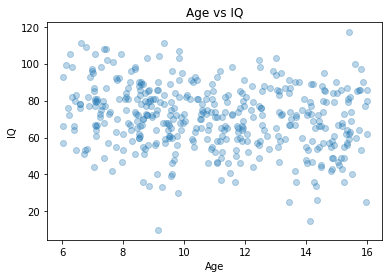

In [97]:
subject_scores = wisc_labels["assessment WISC,WISC_FSIQ_Sum"].to_numpy()
print("Average IQ:", np.mean(subject_scores))

plt.title("Age vs IQ")
plt.scatter(subject_ages, subject_scores, alpha=0.3, label='Ground Truth')
plt.xlabel('Age')
plt.ylabel('IQ')
plt.show()

## Dimensionality Reduction

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [50]:
fc_matrices = []
wisc_measure = []

for features in subjects_with_wisc.values():
    fc_matrices.append(features[0])
    wisc_measure.append(features[1])

X = np.array(fc_matrices)
y = np.array(wisc_measure)

print("X shape:", X.shape, "y shape:", y.shape)

(425, 34716) (425,)


In [122]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=200), LinearRegression())
pcr.fit(X, y)

pls = PLSRegression(n_components=1)
pls.fit(X, y)

PLSRegression(n_components=1)

In [123]:
pca = pcr.named_steps['pca']
X_pca = pca.transform(X)

print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))
print(pca.components_.shape)
print(X_pca.shape)

X_pls = pls.transform(X)
print(X_pls.shape)

[0.21051495 0.05001101 0.03330409 0.02455168 0.02374508 0.01790609
 0.0145931  0.01331055 0.0118863  0.01098084 0.01067763 0.00946387
 0.00897839 0.00826804 0.00776938 0.00737426 0.00717091 0.00682872
 0.00643352 0.00605029 0.00595815 0.00585114 0.00568685 0.00525612
 0.0051542  0.00509451 0.00480911 0.00462753 0.00456849 0.0044304
 0.00431386 0.00426027 0.00400373 0.00396899 0.00386691 0.00381628
 0.00372803 0.00365332 0.00357828 0.00354297 0.00346407 0.00339482
 0.00337467 0.00334324 0.00329352 0.0032358  0.00321929 0.00311481
 0.00309773 0.00307566 0.00302749 0.00297843 0.00295214 0.00289353
 0.00285811 0.00282987 0.00280496 0.0027245  0.00271313 0.00268935
 0.0026639  0.00263302 0.00259347 0.00257411 0.00255485 0.00252059
 0.00250793 0.00245361 0.00244667 0.00240744 0.00240544 0.00236712
 0.00234383 0.00232722 0.00227516 0.00226775 0.00225296 0.00221633
 0.00217593 0.0021579  0.002145   0.00213401 0.00213074 0.00211138
 0.00209284 0.00207036 0.00205598 0.00203209 0.00202231 0.00199

In [124]:
reg = pcr.named_steps['linearregression']
y_pcr_pred = reg.predict(X_pca)
y_pls_pred = pls.predict(X)

print("PCR Coef:", reg.coef_)
print("PCR r^2:", reg.score(X_pca, y))
print("PLS r^2:", pls.score(X, y))

PCR Coef: [-1.68251805e-02  2.25532725e-02  1.77137703e-02  2.75349580e-02
 -4.18574437e-02 -4.32319306e-02 -7.18254745e-02  2.21212059e-02
  1.10645955e-02 -6.74231909e-03  1.38109580e-01  6.64030015e-02
 -1.48948848e-01  1.12201221e-01  5.07413149e-02  2.34383419e-02
  9.95999873e-02  3.24136987e-02  1.50969744e-01  1.16766617e-01
  1.42476678e-01  4.88989428e-02 -2.34682247e-01 -3.44592333e-03
  1.80569902e-01 -1.11164600e-02 -1.57153718e-02 -3.78452018e-02
  1.18827179e-01 -1.84713989e-01 -2.86220834e-02  6.06702045e-02
 -1.47689968e-01  7.03640729e-02 -2.78999414e-02  2.36573741e-02
 -6.04616664e-02 -9.62738991e-02  2.90256999e-02 -2.09168494e-02
 -5.04359603e-03 -3.83933187e-02 -9.86650586e-02  8.98837745e-02
  5.75258397e-02  1.39105529e-01 -1.16903022e-01  2.06533566e-01
 -1.28688924e-02  2.24142522e-03 -3.12226266e-03 -3.59955914e-02
 -1.75159797e-03 -1.35284171e-01  4.78785709e-02 -1.26580894e-02
 -4.43678834e-02 -3.15497480e-02 -9.13288072e-03  5.20535931e-02
 -1.23561502e-0

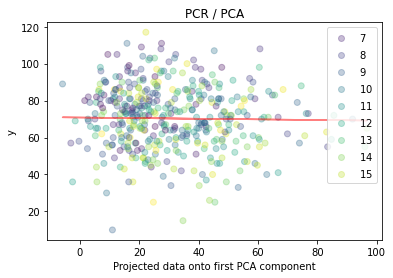

In [116]:
plt.title("PCR / PCA")
scatter = plt.scatter(X_pca, y, c=subject_ages, alpha=0.3, label='Ground Truth')
plt.plot(X_pca, y_pcr_pred, alpha=0.5, color='red', label="Predictions")
plt.xlabel('Projected data onto first PCA component')
plt.ylabel('y')
plt.legend(*scatter.legend_elements())
plt.show()

In [91]:
# REMOVE OUTLIER
# outlier_indices = np.where(X_pls < -200)
# print(outlier_indices)
# X_pls = np.delete(X_pls, outlier_indices)
# y = np.delete(y, outlier_indices)
# subject_ages = np.delete(subject_ages, outlier_indices)

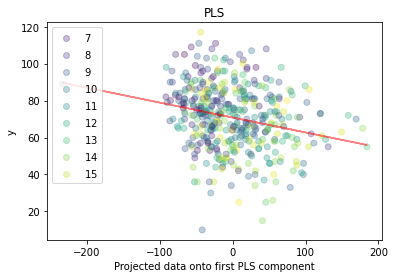

In [117]:
plt.title("PLS")
plt.scatter(X_pls, y, c=subject_ages, alpha=0.3, label='Ground Truth')
plt.plot(X_pls, y_pls_pred, alpha=0.5, color='red', label="Predictions")
plt.xlabel('Projected data onto first PLS component')
plt.ylabel('y')
plt.legend(*scatter.legend_elements())
plt.show()

## Regularization

In [109]:
from sklearn.linear_model import Ridge
from sklearn.metrics import median_absolute_error

In [110]:
ridge = Ridge()
ridge.fit(X, y)

y_ridge = ridge.predict(X)
mae = median_absolute_error(y, y_ridge)
print("MAE:", mae)
print("Ridge r^2:", ridge.score(X, y))

MAE: 0.01706695556640625
Ridge r^2: 0.9999969158116732


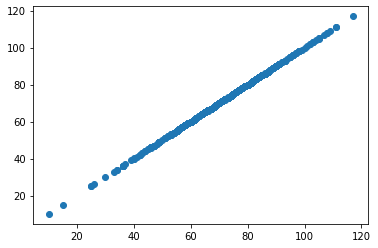

In [111]:
plt.scatter(y, y_ridge)

In [113]:
print(np.amin(ridge.coef_), np.amax(ridge.coef_))
coefs = pd.DataFrame(ridge.coef_)
display(coefs)

-0.29948798 0.30560026


,0
0,-0.060805
1,-0.101766
2,-0.102499
3,0.085956
4,-0.097726
...,...
34711,-0.101380
34712,-0.118444
34713,0.014623
34714,0.089787
